# Testing HW equilibrium

- Initial population: 10000
- Fertility rate: 2.0
- Random mating parameters being explored: 1, 0.3, 0
- Allele frequency = 0.45 - 0.55
- I am using previous restriction: reproduction time (35 years), no mixing between siblings and cousins, parents and offsprings 

In [272]:
library(data.table)
library(lfa)
library(ggplot2)
library(patchwork)
library(HardyWeinberg)
output_path = "../output/data/"
rep = 1

In [197]:
# read data
dat = fread(paste0(output_path, "agents-snp-hw.csv"))
params = fread(paste0(output_path, "param-snp-hw.csv"))
rr = fread(paste0(output_path, "results-snp-hw.csv"))
# create id
dat[, id := .GRP, .(iteration, replicate)]


In [198]:
# final population
summary(rr$population)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  24326   24491   24655   24614   24758   24861 

In [199]:
table(dat$generation)


    0     1     2     3 
45000 39749 35698 36566 

In [200]:
# snp text to numeric
vars = paste0("snp", 0:99)
dat[, agent_id := 1:.N]
dat[, (vars) := tstrsplit(snps, ",", fixed=TRUE)]
dat[, (vars) := lapply(.SD, function(x) factor(as.numeric(gsub(".+=|\\}", "", x)), levels = 0:2)), .SDcols = vars]
df = merge(dat, params[, .(iteration, replicate, random_mating)], by = c("iteration", "replicate"))
rr = merge(rr, params[, .(iteration, replicate, random_mating)], by = c("iteration", "replicate"))

In [201]:
# prop.table(table(dat[generation == 0, snp2]))
# prop.table(table(dat[generation == check_generation, snp2]))

In [202]:
# testing transformation from snp text to columns
ss = sample(nrow(dat), 1)
dat[ss, snps]
dat[ss, ..vars]

[1] "{0=2.0, 1=2.0, 2=0.0, 3=2.0, 4=2.0, 5=1.0, 6=0.0, 7=1.0, 8=1.0, 9=1.0, 10=0.0, 11=1.0, 12=2.0, 13=1.0, 14=1.0, 15=0.0, 16=1.0, 17=1.0, 18=0.0, 19=0.0, 20=0.0, 21=0.0, 22=1.0, 23=0.0, 24=1.0, 25=0.0, 26=0.0, 27=1.0, 28=1.0, 29=0.0, 30=1.0, 31=1.0, 32=0.0, 33=2.0, 34=1.0, 35=2.0, 36=1.0, 37=2.0, 38=0.0, 39=1.0, 40=1.0, 41=1.0, 42=2.0, 43=1.0, 44=0.0, 45=1.0, 46=1.0, 47=1.0, 48=0.0, 49=2.0, 50=1.0, 51=2.0, 52=0.0, 53=1.0, 54=1.0, 55=0.0, 56=0.0, 57=0.0, 58=1.0, 59=1.0, 60=0.0, 61=1.0, 62=1.0, 63=1.0, 64=0.0, 65=0.0, 66=1.0, 67=1.0, 68=1.0, 69=1.0, 70=0.0, 71=1.0, 72=1.0, 73=1.0, 74=0.0, 75=1.0, 76=1.0, 77=1.0, 78=1.0, 79=1.0, 80=0.0, 81=1.0, 82=2.0, 83=1.0, 84=1.0, 85=1.0, 86=0.0, 87=1.0, 88=2.0, 89=2.0, 90=1.0, 91=1.0, 92=1.0, 93=1.0, 94=1.0, 95=1.0, 96=1.0, 97=2.0, 98=0.0, 99=1.0}"

snp0,snp1,snp2,snp3,snp4,snp5,snp6,snp7,snp8,snp9,...,snp90,snp91,snp92,snp93,snp94,snp95,snp96,snp97,snp98,snp99
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
2,2,0,2,2,1,0,1,1,1,...,1,1,1,1,1,1,1,2,0,1


In [180]:

# standard function to test HW
getHWsnps = function(data, idvar = "id", snps = paste0("snp", 0:99)) {
    ids = unique(data[[idvar]])
    pvalues = NULL
    for (i in ids) {
        temp = copy(data[get(idvar) == i])
        for (ii in snps) {
            t = table(temp[, get(ii)])
            allele = c("AA", "AB", "BB")
            t = as.vector(t)
            names(t) = allele
            pvalues = c(pvalues, HWChisq(t, verbose = FALSE)$pval)
        }
    }
    return(pvalues)
}

# This function is computationally expensive
getHWpvalues = function(data, idvar = "id", k = 1, nsample = NULL) {
    ids = unique(data[[idvar]])
    pvalues = NULL
    vars = names(data)[grepl("^snp[0-9]+$", names(data))] 
    for (i in ids) {
        temp = copy(data[id == i, ..vars])
        m = as.matrix(transpose(temp))
        # use k=1 for standard HW test
        LF = lfa(m, k)
        pvalues = c(pvalues, sHWE(m, LF, 4))
    }
    print(summary(pvalues))
    return(pvalues)
}

# Assortative mating (BMI)


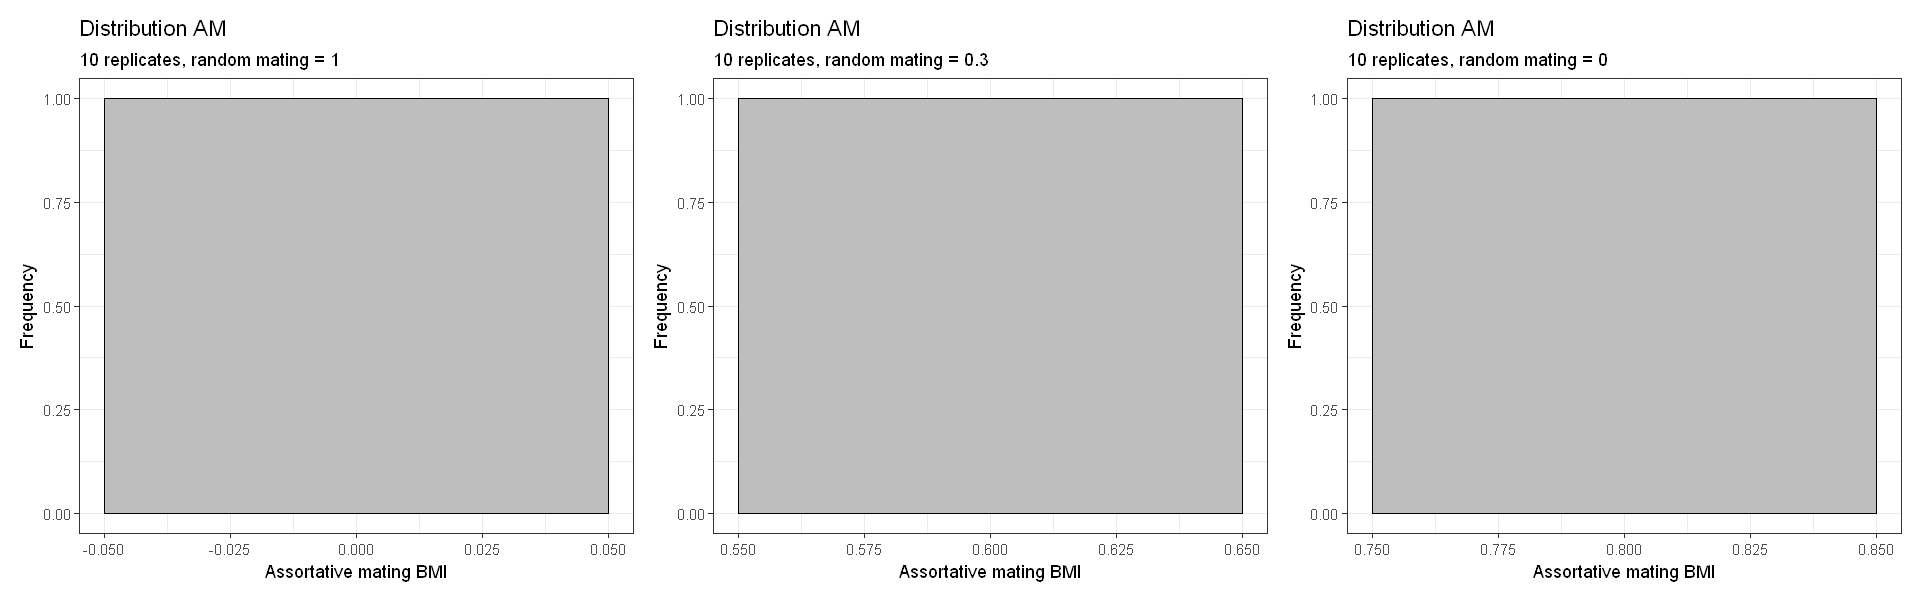

In [273]:
options(repr.plot.width=16, repr.plot.height=5)
plots = list() 
values = c(1, 0.3, 0)
for (i in 1:3) {
plots[[i]] = ggplot(rr[random_mating == values[i], .(am_bmi)], aes(am_bmi)) + 
    geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "Assortative mating BMI", y = "Frequency", 
    title = "Distribution AM", 
        subtitle = paste0(nrep, " replicates, random mating = ", values[i]))
}
wrap_plots(plots)

# Contrasting generations

## Generation 0 

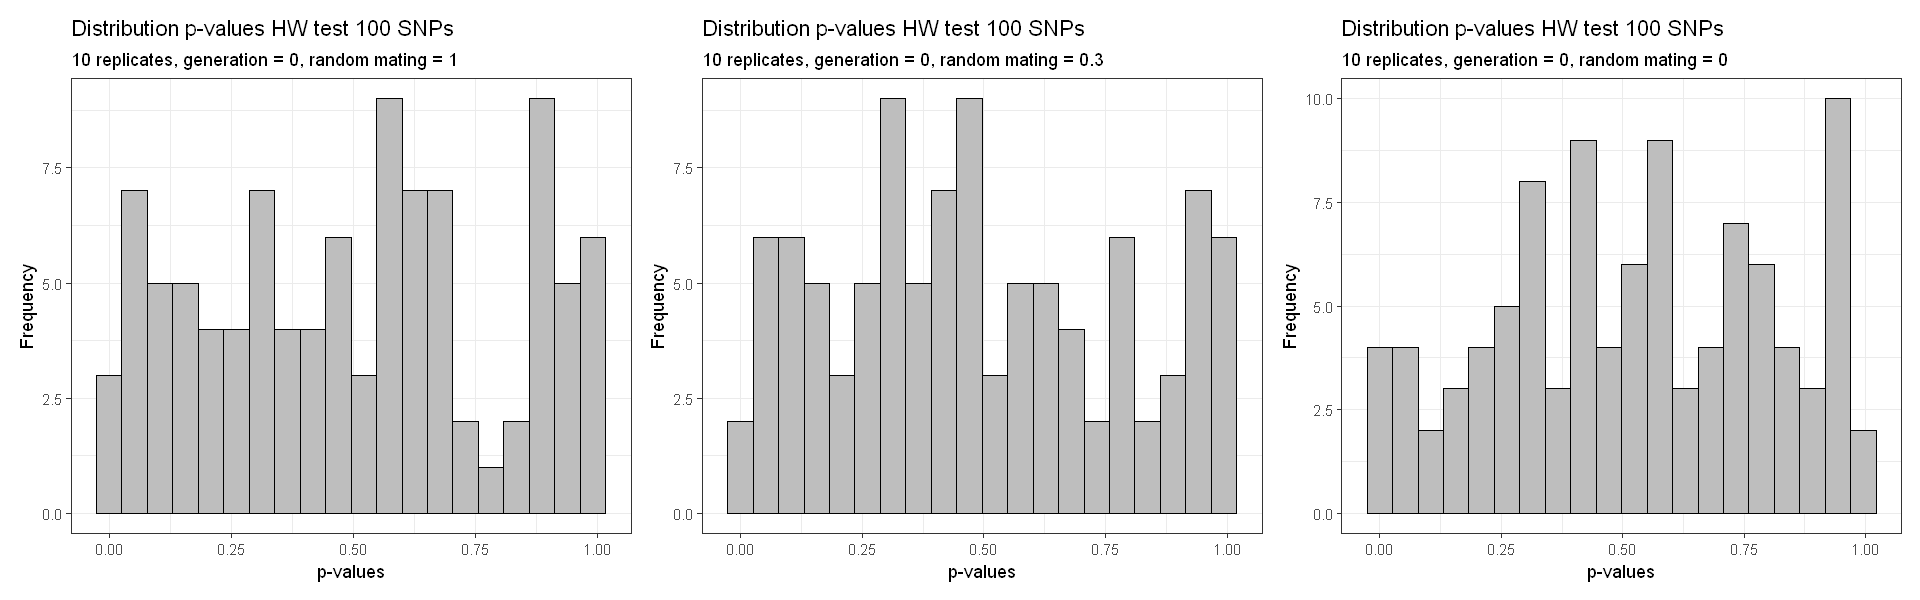

In [274]:
check_generation = 0
pvalues0rm0 = getHWsnps(df[generation == 0 &  random_mating == 0])
pvalues0rm03 = getHWsnps(df[generation == 0 &  random_mating == 0.3])
pvalues0rm1 = getHWsnps(df[generation == 0 &  random_mating == 1])

plots = list() 
vars = c("pvalues0rm1", "pvalues0rm03", "pvalues0rm0") 
values =  c(1, 0.3, 0)
for (i in 1:3) {
plots[[i]] = ggplot(data.table(pvalues = get(vars[i])), aes(pvalues)) + 
    geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
        title = "Distribution p-values HW test 100 SNPs", 
        subtitle = paste0(nrep, " replicates, generation = ", check_generation, ", random mating = ", values[i]))
}
wrap_plots(plots)

# Generation 1

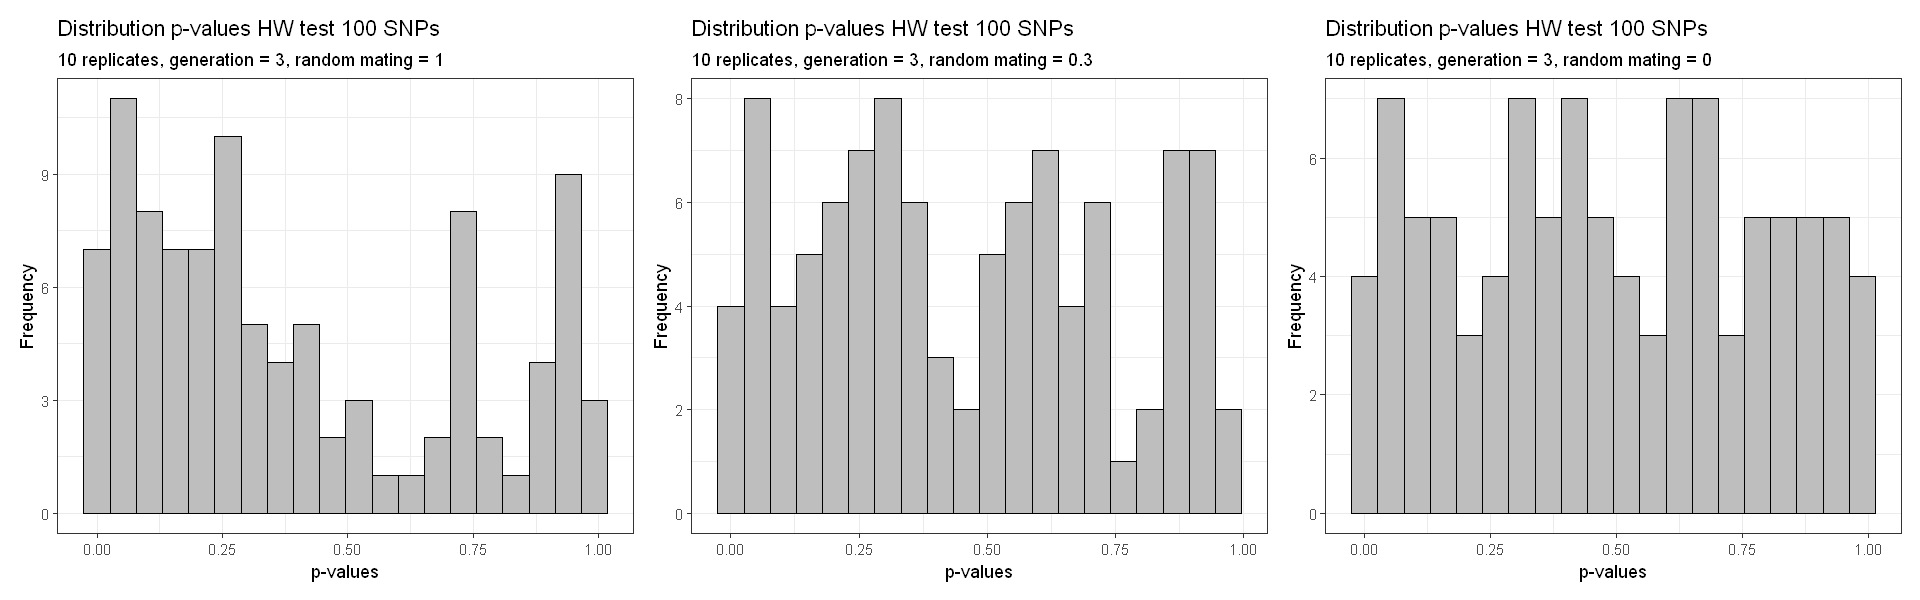

In [275]:
check_generation = 3
pvalues1rm0 = getHWsnps(df[generation == check_generation &  random_mating == 0])
pvalues1rm03 = getHWsnps(df[generation == check_generation &  random_mating == 0.3])
pvalues1rm1 = getHWsnps(df[generation == check_generation &  random_mating == 1])


plots = list() 
vars = c("pvalues1rm1", "pvalues1rm03", "pvalues1rm0") 
values =  c(1, 0.3, 0)
for (i in 1:3) {
plots[[i]] = ggplot(data.table(pvalues = get(vars[i])), aes(pvalues)) + 
    geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
        title = "Distribution p-values HW test 100 SNPs", 
        subtitle = paste0(nrep, " replicates, generation = ", check_generation, ", random mating = ", values[i]))
}
wrap_plots(plots)

## Generation 10

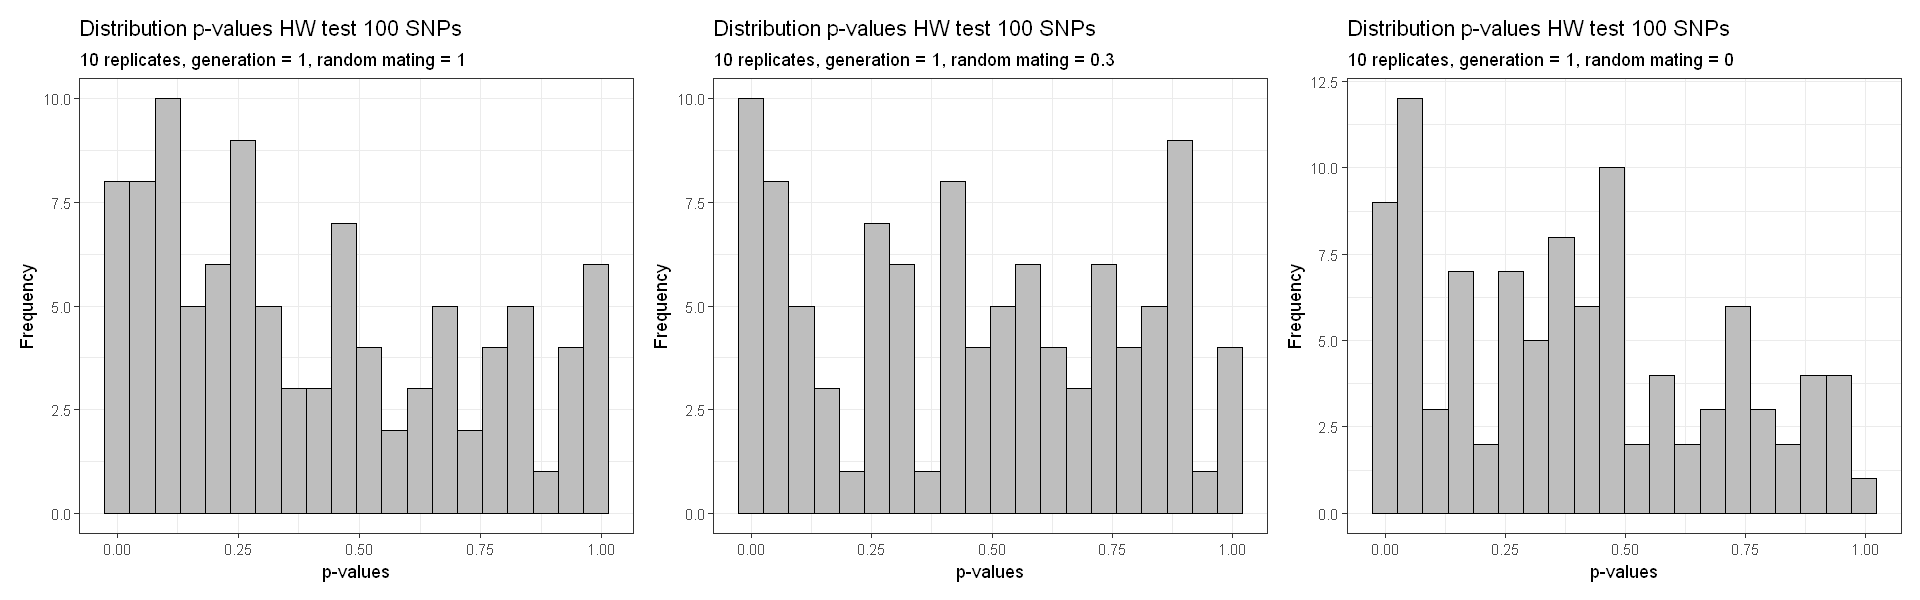

In [276]:
check_generation = 1
pvalues1rm0 = getHWsnps(df[generation == check_generation &  random_mating == 0])
pvalues1rm03 = getHWsnps(df[generation == check_generation &  random_mating == 0.3])
pvalues1rm1 = getHWsnps(df[generation == check_generation &  random_mating == 1])


plots = list() 
vars = c("pvalues1rm1", "pvalues1rm03", "pvalues1rm0") 
values =  c(1, 0.3, 0)
for (i in 1:3) {
plots[[i]] = ggplot(data.table(pvalues = get(vars[i])), aes(pvalues)) + 
    geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
        title = "Distribution p-values HW test 100 SNPs", 
        subtitle = paste0(nrep, " replicates, generation = ", check_generation, ", random mating = ", values[i]))
}
wrap_plots(plots)

# Testing recombination with several kids (siblings)

In [254]:
# testing recombination
recombination = function(a) {
    alleles = c(0, 1, 2)
    v = a[1] * 10 + a[2]
    if (v == 0) return(0);
    if (v %in% c(1, 10)) return(sample(alleles, 1, prob = c(0.5, 0.5, 0)))
    if (v %in% c(2, 20)) return(1);
    if (v == 11) return(sample(alleles, 1, prob = c(0.25, 0.5, 0.25)));
    if (v %in% c(12, 21)) return(sample(alleles, 1, prob = c(0.0, 0.5, 0.5)));
    if (v == 22) return(2);
}


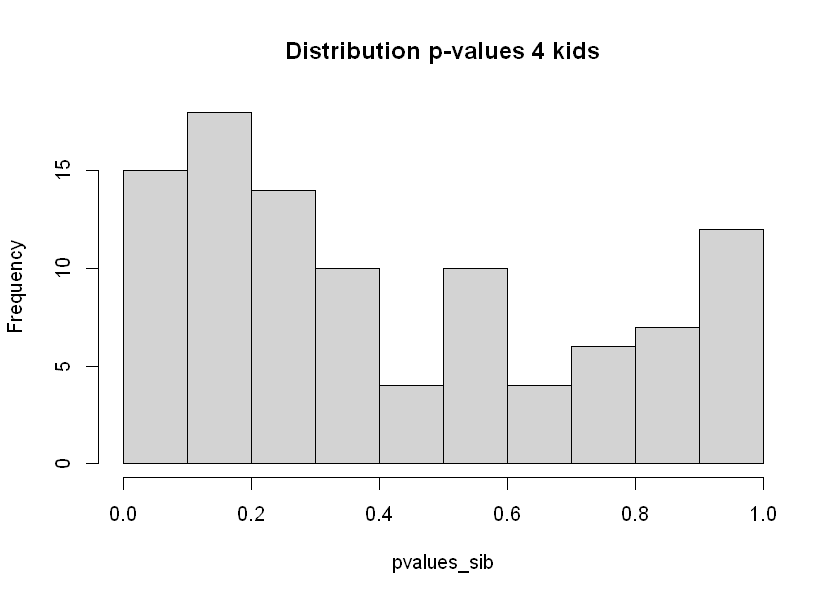

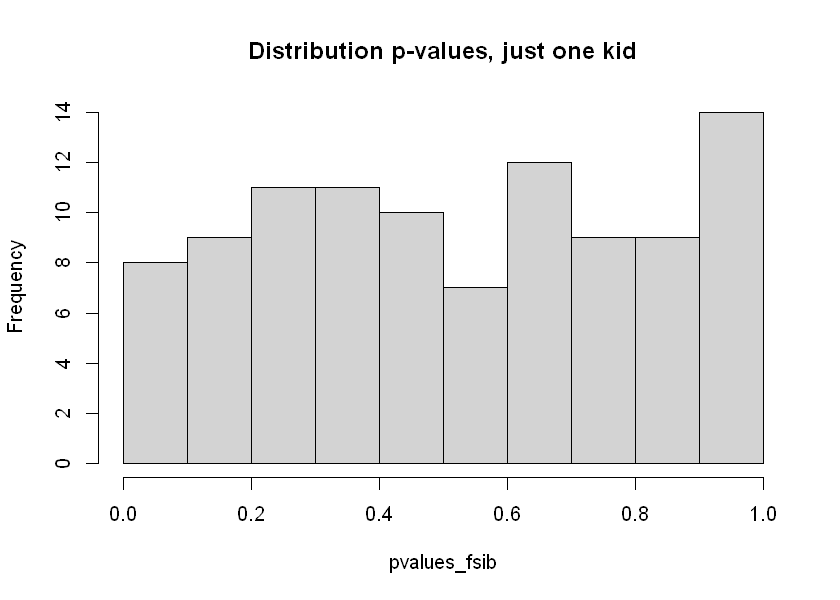

In [270]:
options(repr.plot.width=7, repr.plot.height=5)
pvalues_sib = NULL
pvalues_fsib = NULL
for (i in 1:100) {

    n = 1000
    p = 0.5
    dat = data.table(a= rbinom(n, 2, p), b = rbinom(n, 2, p))
    dat[, c := apply(.SD, 1, recombination)]
    dat[, d := apply(.SD, 1, recombination)]
    dat[, e := apply(.SD, 1, recombination)]
    dat[, f := apply(.SD, 1, recombination)]
    t = table(c(dat$c, dat$d, dat$e, dat$f))
    l = c("AA", "AB", "BB")
    t = as.vector(t)
    names(t) = l
    pvalues_sib = c(pvalues_sib, HWChisq(t, verbose = FALSE)$pval)

    t = table(dat$c)
    l = c("AA", "AB", "BB")
    t = as.vector(t)
    names(t) = l
    pvalues_fsib = c(pvalues_fsib, HWChisq(t, verbose = FALSE)$pval)
}

hist(pvalues_sib, main = "Distribution p-values 4 kids" )
hist(pvalues_fsib, main = "Distribution p-values, just one kid")

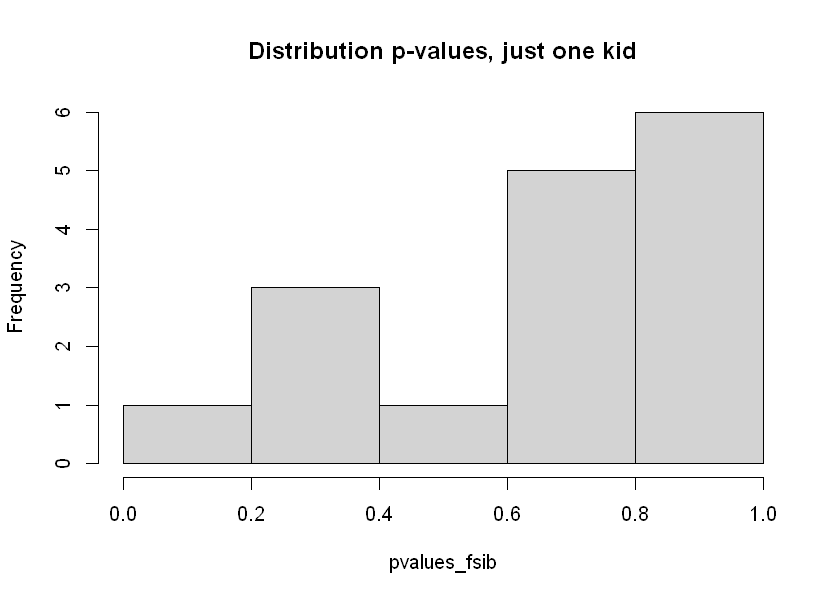

In [278]:
# testing from anylogic
options(repr.plot.width=7, repr.plot.height=5)
a1 = c(0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0)
a2 = c(2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0)
a3 = c(0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0)
a4 = c(1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 2.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0)
a5 = c(1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 0.0, 2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0)
a6 = c(2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0)
a7 = c(0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 0.0, 2.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0)
a8 = c(1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0)
a9 = c(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0)
a10 = c(0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0)
a11 = c(1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0)
a12 = c(0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 2.0, 2.0, 1.0)
a13 = c(0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0)
a14 = c(0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0)
a15 = c(0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0)
a16 = c(2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0)

pvalues_fsib = NULL
for (i in 1:16) {
    t = table(get(paste0("a", i)))
    l = c("AA", "AB", "BB")
    t = as.vector(t)
    names(t) = l
    pvalues_fsib = c(pvalues_fsib, HWChisq(t, verbose = FALSE)$pval)
}

hist(pvalues_fsib, main = "Distribution p-values, just one kid")